## Case Study: Random Forest

This practical use case aims to solve a malware detection problem on Android devices by analyzing the network traffic generated by the device through the use of decision trees.

### Dataset: Android Malware Detection

### Description

#### 

The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behavior to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. See our publicly available Android Sandbox.

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1900 applications with the following three categories:

  1. Adware (250 apps)

  - Airpush: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.
  - Dowgin: Designed as an advertisement library that can also steal the user’s information.
  - Kemoge: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.
  - Mobidash: Designed to display ads and to compromise user’s personal information.
  - Shuanet: Similar to Kemoge, Shuanet also is designed to take over a user’s device.
  
  2. General Malware (150 apps)

  - AVpass: Designed to be distributed in the guise of a Clock app.
  - FakeAV: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.
  - FakeFlash/FakePlayer: Designed as a fake Flash app in order to direct users to a website (after successfully installed).
  - GGtracker: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.
  - Penetho: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via     infected email attachment, fake updates, external media and infected documents.
  
  3. Benign (1500 apps)

  - 2015 GooglePlay market (top free popular and top free new)
  - 2016 GooglePlay market (top free popular and top free new)
  
### Ficheros de datos
    - pcap files – the network traffic of both the malware and benign (20% malware and 80% benign)
    - .csv files - the list of extracted network traffic features generated by the CIC-flowmeter


### Downloading the data files 
    - https://www.unb.ca/cic/datasets/android-adware.html 
  

### Imports


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score
from pandas import DataFrame
import matplotlib.pyplot as plt

### Auxillary Functions

In [2]:
# Building a function that performs full partitioning
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))

### 1. Reading the data set

In [4]:
df = pd.read_csv("data/Phishing.csv")

### 2. Preview of information

In [5]:
df.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign


In [6]:
df.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15096.000000,15367.000000,15367.000000,15367.000000,15367.000000,...,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,15367.000000,13541.000000,15177.000000,15364.000000,15364.000000
mean,3.446021,2.543698,8.477061,5.851956,10.027461,5.289936,2.543698,12.659986,8.398516,1.910913,...,2.120843,1.124618,0.500813,-0.158782,0.721684,0.854232,0.634859,0.682896,0.313617,-0.723793
std,14.151453,0.944938,4.660250,2.064581,5.281090,3.535097,0.944938,8.562206,6.329007,4.657731,...,2.777307,2.570246,2.261013,2.535939,0.049246,0.072641,0.510992,0.502288,0.576910,0.649785
min,0.000000,2.000000,0.000000,1.500000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.419560,0.561913,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,5.000000,4.500000,7.000000,3.800000,2.000000,6.000000,4.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.687215,0.798231,0.709532,0.707165,0.000000,-1.000000
50%,0.000000,2.000000,8.000000,5.500000,9.000000,4.500000,2.000000,11.000000,7.000000,0.000000,...,2.000000,0.000000,0.000000,-1.000000,0.723217,0.859793,0.785949,0.814038,0.000000,-1.000000
75%,0.000000,3.000000,11.000000,6.666666,12.000000,5.571429,3.000000,17.000000,11.000000,1.000000,...,3.000000,1.000000,0.000000,-1.000000,0.757949,0.916667,0.859582,0.916667,1.000000,-1.000000
max,173.000000,19.000000,68.000000,29.500000,63.000000,105.000000,19.000000,94.000000,62.000000,58.000000,...,24.000000,31.000000,30.000000,29.000000,0.869701,1.000000,0.962479,1.000000,1.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

In [8]:
# Checking for the existence of infinite values
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

argPathRatio    True
dtype: bool

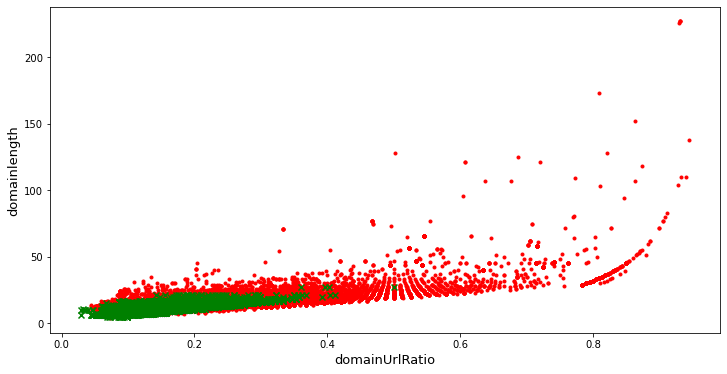

In [9]:
# Graphical representation of two characteristics
plt.figure(figsize=(12, 6))
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "phishing"], df["domainlength"][df['URL_Type_obf_Type'] == "phishing"], c="r", marker=".")
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "benign"], df["domainlength"][df['URL_Type_obf_Type'] == "benign"], c="g", marker="x")
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

### 3. Division of the data set

In [10]:
# Division of the data set
train_set, val_set, test_set = train_val_test_split(df)


In [11]:
X_train = train_set.drop("URL_Type_obf_Type", axis=1)
y_train = train_set["URL_Type_obf_Type"].copy()

X_val = val_set.drop("URL_Type_obf_Type", axis=1)
y_val = val_set["URL_Type_obf_Type"].copy()

X_test = test_set.drop("URL_Type_obf_Type", axis=1)
y_test = test_set["URL_Type_obf_Type"].copy()

### 4. Preparation of the data set

In [12]:
# We remove the attribute that has infinite values
X_train = X_train.drop("argPathRatio", axis=1)
X_val = X_val.drop("argPathRatio", axis=1)
X_test = X_test.drop("argPathRatio", axis=1)

In [13]:
# We fill the null values ​​with the median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [14]:
# We fill the null values 
X_train_prep = imputer.fit_transform(X_train) 
X_val_prep = imputer.fit_transform(X_val) 
X_test_prep = imputer.fit_transform(X_test)

In [15]:
# We transform the result to a Pandas DataFrame
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)
X_train_prep.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
2134,0.0,2.0,6.0,2.000000,2.0,8.666667,2.0,17.0,10.0,0.0,...,2.0,0.0,0.0,-1.0,0.681183,0.827729,0.702637,0.849605,0.000000,-1.000000
9178,0.0,4.0,18.0,3.250000,5.0,1.000000,4.0,18.0,13.0,2.0,...,12.0,3.0,0.0,4.0,0.695232,0.820160,0.682849,0.875578,0.000000,0.778747
13622,0.0,3.0,3.0,6.666666,14.0,4.000000,3.0,1.0,1.0,1.0,...,1.0,0.0,0.0,-1.0,0.836006,0.869991,0.879588,1.000000,0.000000,-1.000000
15182,0.0,3.0,5.0,3.333333,4.0,3.000000,3.0,5.0,2.0,0.0,...,2.0,1.0,0.0,-1.0,0.731804,0.796490,0.796658,1.000000,1.000000,-1.000000
8013,74.0,2.0,13.0,9.500000,17.0,7.875000,2.0,21.0,29.0,26.0,...,4.0,5.0,4.0,3.0,0.653371,0.820569,0.758055,0.714969,0.712215,0.708031


In [16]:
# We check for null values ​​in the training data set
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

### 5. Decision Tree

In [17]:
from sklearn.ensemble import RandomForestClassifier
# Model trained with the unscaled data set
clf_tree = RandomForestClassifier()
clf_tree.fit(X_train_prep, y_train)

RandomForestClassifier()

In [18]:
# We predict with the training dataset
y_train_pred = clf_tree.predict(X_val_prep)

In [19]:
from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_train_pred, y_val, pos_label='phishing'))

F1 Score: 0.9824677472709229
